# Hail Forecasting v0.1

# Import Packages

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from sklearn.impute import SimpleImputer

import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score

# Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# load data
df_og = pd.read_csv('/content/drive/My Drive/Hackathon_20231007/Cleaned hackathon solutions/hail_predictors_10K.csv')
df_og = df_og.rename(columns={'Unnamed: 0': 'ID'})
# trainining data is everything prior to year 2022
df_train = df_og.where(df_og['year'] < 2022).dropna(how = 'all')
df_train_cleared = df_train.drop(columns=['ID','year', 'month','day','hour','start_time','latitude','longitude','event'])
# create targets and predictors dataframes
y_train0 = df_train_cleared[['hail_size', 'y_thunderstorm', 'y_hail', 'y_severe']]
X_train0 = df_train_cleared.drop(columns=['hail_size', 'y_thunderstorm', 'y_hail', 'y_severe'])
# create evaluation dataframe
df_eval = df_og.where(df_og['year'] == 2022).dropna(how = 'all')
df_eval_cleared = df_eval.drop(columns=['ID','year', 'month','day','hour','start_time','latitude','longitude','event'])

X_eval = df_eval_cleared.drop(columns=['hail_size', 'y_thunderstorm', 'y_hail', 'y_severe'])
thunder_X_eval = X_eval.drop(columns=[col for col in X_eval.columns if not col.find('LD')]) # specific eval dataframe for thunderstorms removes lightning data
# list of columns of target and predictor dataframes
target_cols = y_train0.columns
driver_cols = X_train0.columns

In [4]:
X = X_train0
y = y_train0

In [5]:
y['y_thunderstorm'] = y['y_thunderstorm'].astype(int)
y['y_hail'] = y['y_hail'].astype(int)
y['y_severe'] = y['y_severe'].astype(int)

<ipython-input-5-75c3ac2b3667>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['y_thunderstorm'] = y['y_thunderstorm'].astype(int)
<ipython-input-5-75c3ac2b3667>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['y_hail'] = y['y_hail'].astype(int)
<ipython-input-5-75c3ac2b3667>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
df_pred = df_eval

In [ ]:
def train_and_pred(boosting_model, y_column, pred_name, use_weights=False):
  imputer = SimpleImputer(strategy='mean')
  X_train_imputed = imputer.fit_transform(X_train)
  X_test_imputed = imputer.transform(X_test)

  # Apply weights if required
  if use_weights and y_column == 'y_hail':
      weights = []
      for hail_size in y_train['hail_size']:
        # no hail
        if hail_size == 0:
          weights.append(1)
        # non-severe hail
        elif hail_size < 20:
          weights.append(2)
        # severe hail
        elif 20 <= hail_size <= 50:
          weights.append(3)
        # seriously severe hail
        else:
          weights.append(4)
      boosting_model.fit(X_train_imputed, y_train[y_column], sample_weight=weights)
  else:
      boosting_model.fit(X_train_imputed, y_train[y_column])

  y_pred = boosting_model.predict(X_test_imputed)

  # Evaluate the model
  from sklearn.metrics import f1_score

  # Assuming y_test and y_pred are your true labels and predicted labels, respectively
  f1_micro = f1_score(y_test[y_column], y_pred, average='micro')

  print(f"F1 Micro Score: {f1_micro:.2f}")
  X_to_predict = X_eval

  imputer = SimpleImputer(strategy='mean')
  X_to_predict_imputed = imputer.fit_transform(X_to_predict)

  X_to_predict_imputed_df = pd.DataFrame(X_to_predict_imputed, columns=X_to_predict.columns)
  X_to_predict_imputed_df

  df_pred = df_eval
  predictions = boosting_model.predict(X_to_predict_imputed_df)
  predictions = predictions.astype(bool)
  df_pred[pred_name] = predictions

In [ ]:
def find_important_features(boosting_model, limit):
  features_all = boosting_model.feature_importances_
  dataset_all_columns = X_train.columns.values[features_all > limit].reshape(-1, 1)
  features_all_trimmed = features_all[features_all > limit].reshape(-1, 1)
  indices = np.arange(0, 1260, 1)[features_all > limit].reshape(-1, 1)
  ranked_features = np.concatenate([indices, dataset_all_columns, features_all_trimmed], axis = 1)
  sorted_ranked_features = sorted(ranked_features.tolist(), key = lambda kvvp: kvvp[2])[::-1]
  return sorted_ranked_features

# Training Hail Forecasting Model

In [ ]:
hail_boosting_model = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    n_estimators=50,            # Number of boosting rounds (you can adjust this)
    learning_rate=0.1,           # Learning rate (you can adjust this)
    max_depth=4,                 # Maximum depth of each tree (you can adjust this)
    random_state=42
)

In [ ]:
train_and_pred(
    boosting_model=hail_boosting_model,
    y_column='y_hail',
    pred_name='pred_y_hail'
)

F1 Micro Score: 0.99


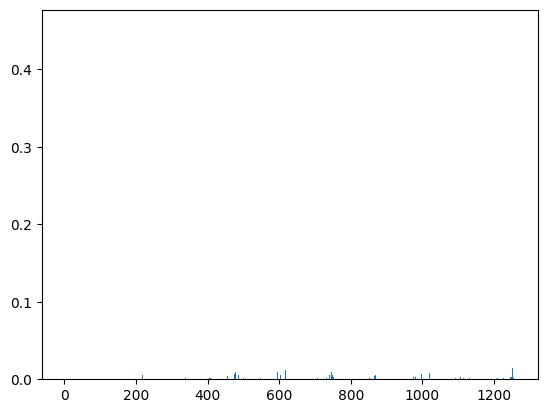

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(len(hail_boosting_model.feature_importances_)), hail_boosting_model.feature_importances_)
plt.show()

In [ ]:
hail_important_features = find_important_features(
    boosting_model=hail_boosting_model,
    limit=0.01
)

In [ ]:
hail_important_features

[[1254, 'LD.t-2', 0.45423978567123413],
 [1253, 'LD.t-3', 0.03276574984192848],
 [1259, 'LD.t+3', 0.02527746371924877],
 [1250, 'LD.t-6', 0.01800261251628399],
 [1252, 'LD.t-4', 0.014624247327446938],
 [618, 'lapse_rate_0_3_km.t-2', 0.011658738367259502]]

In [ ]:
hail_important_features_names = [feature[1] for feature in hail_important_features]
hail_important_features_values = [feature[2] for feature in hail_important_features]

In [ ]:
hail_important_features_names

['LD.t-2', 'LD.t-3', 'LD.t+3', 'LD.t-6', 'LD.t-4', 'lapse_rate_0_3_km.t-2']

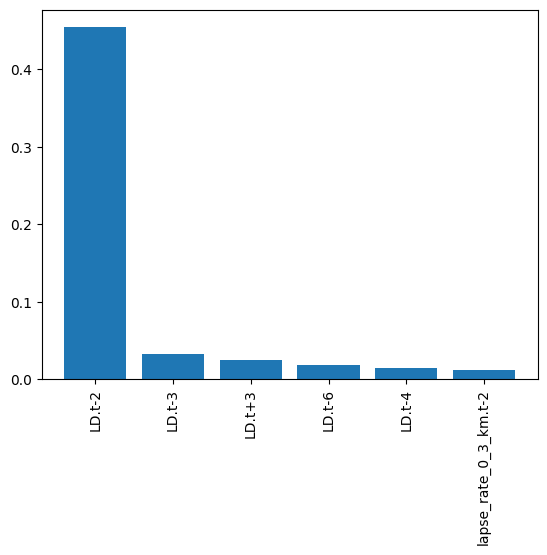

In [ ]:
import matplotlib.pyplot as plt

plt.bar(hail_important_features_names, hail_important_features_values)
plt.xticks(rotation='vertical')  # This line sets the x-axis labels to be vertical
plt.show()

# Training Severe Forecasting Model

In [ ]:
severe_boosting_model = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    n_estimators=50,            # Number of boosting rounds (you can adjust this)
    learning_rate=0.1,           # Learning rate (you can adjust this)
    max_depth=4,                 # Maximum depth of each tree (you can adjust this)
    random_state=42
)

In [ ]:
train_and_pred(
    boosting_model=severe_boosting_model,
    y_column='y_severe',
    pred_name='pred_y_severe'
)

F1 Micro Score: 0.84


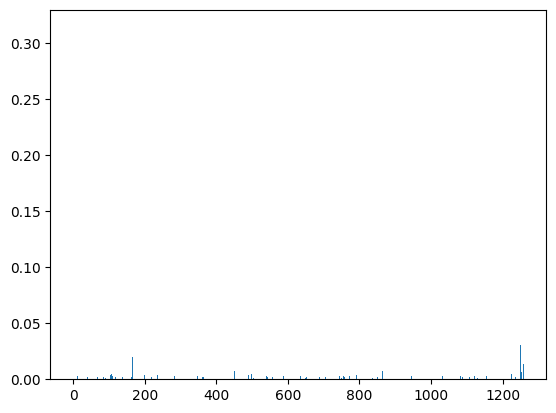

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(len(severe_boosting_model.feature_importances_)), severe_boosting_model.feature_importances_)
plt.show()

In [ ]:
severe_important_features = find_important_features(
    boosting_model=severe_boosting_model,
    limit=0.01
)

In [ ]:
severe_important_features

[[1254, 'LD.t-2', 0.3140465319156647],
 [536, 't_650.t-2', 0.036302655935287476],
 [1250, 'LD.t-6', 0.03029504604637623],
 [166, 't_700.t-5', 0.01948338747024536],
 [41, 't_700.t-6', 0.018891876563429832],
 [1255, 'LD.t-1', 0.015885861590504646],
 [1252, 'LD.t-4', 0.015302356332540512],
 [1258, 'LD.t+2', 0.013963109813630581],
 [1259, 'LD.t+3', 0.013783053494989872],
 [1256, 'LD.t+0', 0.013303417712450027],
 [746, 'cape.t-1', 0.010903374291956425]]

In [ ]:
severe_important_features_names = [feature[1] for feature in severe_important_features]
severe_important_features_values = [feature[2] for feature in severe_important_features]

In [ ]:
severe_important_features_names

['LD.t-2',
 't_650.t-2',
 'LD.t-6',
 't_700.t-5',
 't_700.t-6',
 'LD.t-1',
 'LD.t-4',
 'LD.t+2',
 'LD.t+3',
 'LD.t+0',
 'cape.t-1']

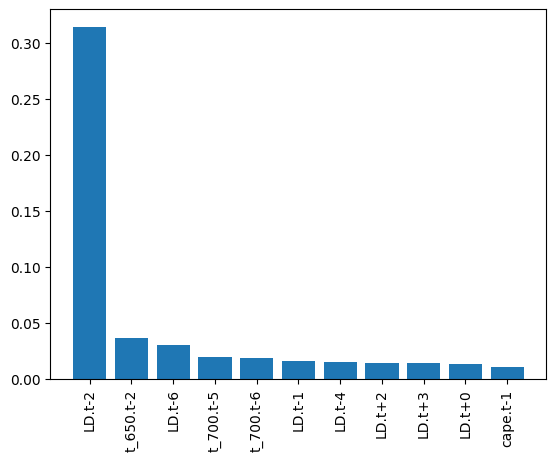

In [ ]:
import matplotlib.pyplot as plt

plt.bar(severe_important_features_names, severe_important_features_values)
plt.xticks(rotation='vertical')  # This line sets the x-axis labels to be vertical
plt.show()

# Putting Weights on Hail Size

In [ ]:
hail_with_weights_boosting_model = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    n_estimators=50,            # Number of boosting rounds (you can adjust this)
    learning_rate=0.1,           # Learning rate (you can adjust this)
    max_depth=4,                 # Maximum depth of each tree (you can adjust this)
    random_state=42
)

In [ ]:
train_and_pred(
    boosting_model=hail_with_weights_boosting_model,
    y_column='y_hail',
    pred_name='pred_y_hail_with_weights',
    use_weights=True
)

F1 Micro Score: 0.99


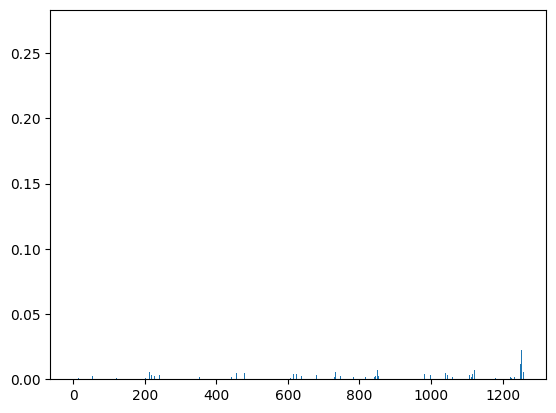

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(len(hail_with_weights_boosting_model.feature_importances_)), hail_with_weights_boosting_model.feature_importances_)
plt.show()

In [ ]:
hail_with_weights_important_features = find_important_features(
    boosting_model=hail_with_weights_boosting_model,
    limit=0.01
)

In [ ]:
hail_with_weights_important_features

[[1254, 'LD.t-2', 0.2698667049407959],
 [1255, 'LD.t-1', 0.19416548311710358],
 [725, 'cp.t-1', 0.022538062185049057],
 [1253, 'LD.t-3', 0.02235289290547371],
 [1123, 'cape_depth_90.t+2', 0.020175710320472717],
 [1259, 'LD.t+3', 0.01757390797138214],
 [595, 'r_1000.t-2', 0.011697246693074703],
 [1250, 'LD.t-6', 0.011608218774199486]]

In [ ]:
hail_with_weights_important_features_names = [feature[1] for feature in hail_with_weights_important_features]
hail_with_weights_important_features_values = [feature[2] for feature in hail_with_weights_important_features]

In [ ]:
hail_with_weights_important_features_names

['LD.t-2',
 'LD.t-1',
 'cp.t-1',
 'LD.t-3',
 'cape_depth_90.t+2',
 'LD.t+3',
 'r_1000.t-2',
 'LD.t-6']

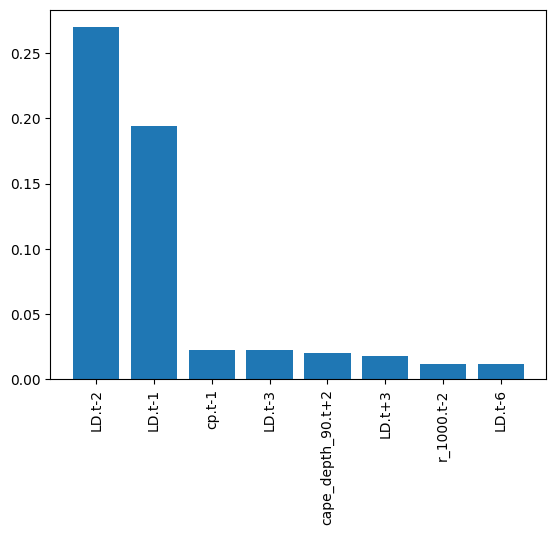

In [ ]:
import matplotlib.pyplot as plt

plt.bar(hail_with_weights_important_features_names, hail_with_weights_important_features_values)
plt.xticks(rotation='vertical')  # This line sets the x-axis labels to be vertical
plt.show()

# Results for `pred_y_hail`,`pred_y_severe`,`pred_y_hail_with_weights`

In [ ]:
# Dichotomous (yes/no) scores
def contingency_table(y_true, y_pred):
    H = np.sum((y_true.ravel()==1)&(y_pred.ravel()==1)) # Hits
    M = np.sum((y_true.ravel()==1)&(y_pred.ravel()==0)) # Misses
    F = np.sum((y_true.ravel()==0)&(y_pred.ravel()==1)) # False alarms
    C = np.sum((y_true.ravel()==0)&(y_pred.ravel()==0)) # Correct negatives
    return H, M, F, C

def POD(H, M, F, C):
    """Probability of detection: how often observed severe hail is predicted
    Takes values between 0 and 1, 1 is best."""
    return H/(H+M)

def POFD(H, M, F, C):
    """Probability of false detection: how often non-severe hail is falsely predicted as severe hail
    Takes values between 0 and 1, 0 is best."""
    return F/(F+C)

def compute_cat_scores(y_true, y_pred):
    H, M, F, C = contingency_table(y_true, y_pred)
    pod = POD(H, M, F, C)
    pofd = POFD(H, M, F, C)
    #edi = EDI(H, M, F, C)
    pss = pod - pofd
    print(f"""
H | F   {H:4} | {F:4}
----- = -------------
M | C   {M:4} | {C:4}

POD   = {pod:0.3}
POFD  = {pofd:0.3}
PSS   = {pss:0.3}
           """)
    return H, M, F, C, pss, pod, pofd

In [ ]:
pred_cols = ['pred_y_hail','pred_y_severe','pred_y_hail_with_weights']
target_cols = ['y_hail','y_severe','y_hail']
labels = ['y_hail','y_severe','y_hail_with_weights']
for i in range(len(pred_cols)):
  print(labels[i], ':')
  compute_cat_scores(df_pred[target_cols[i]], df_pred[pred_cols[i]])

y_hail :

H | F    729 |    0
----- = -------------
M | C      8 |  201

POD   = 0.989
POFD  = 0.0
PSS   = 0.989
           
y_severe :

H | F    319 |  241
----- = -------------
M | C     31 |  347

POD   = 0.911
POFD  = 0.41
PSS   = 0.502
           
y_hail_with_weights :

H | F    730 |    4
----- = -------------
M | C      7 |  197

POD   = 0.991
POFD  = 0.0199
PSS   = 0.971
           


# Categorical Prediction Model (based on hail size) v1

- No sampling

In [ ]:
from sklearn.preprocessing import LabelEncoder

def train_and_predict_categorical_no_sampling(boosting_model, y_column, actual_name, pred_name):
    # Define the categorization function
    def categorize_hail_size(hail_size):
        if hail_size == 0:
            return 'no_hail'
        elif 0 < hail_size < 20:
            return 'non_severe_hail'
        elif 20 <= hail_size <= 50:
            return 'severe_hail'
        elif hail_size > 50:
            return 'seriously_severe_hail'

    # Apply categorization to training and test data
    y_train_filled = y_train[y_column].fillna(0)
    y_train_categorical = y_train_filled.apply(categorize_hail_size)

    # Encode categories to numerical values
    label_encoder = LabelEncoder()
    y_train_categorical_encoded = label_encoder.fit_transform(y_train_categorical)

    # Impute missing values in training data
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Fit the model
    boosting_model.fit(X_train_imputed, y_train_categorical_encoded)

    # Predict on test data
    y_pred = boosting_model.predict(X_test_imputed)

    # Treat NaNs in y_test as 'no_hail'
    y_test_filled = y_test[y_column].fillna(0)
    y_test_categorical = y_test_filled.apply(categorize_hail_size)
    y_test_categorical_encoded = label_encoder.transform(y_test_categorical)

    # Evaluate the model
    f1_micro = f1_score(y_test_categorical_encoded, y_pred, average='micro')
    print(f"F1 Micro Score: {f1_micro:.2f}")

    # Predict on evaluation dataset
    X_to_predict_imputed = imputer.transform(X_eval)
    predictions = boosting_model.predict(X_to_predict_imputed)
    df_pred[pred_name] = label_encoder.inverse_transform(predictions)

    # Apply the same categorization to the hail size data in the evaluation dataset and add to df_pred
    df_eval_filled = df_eval[y_column].fillna(0)
    df_eval_categorical = df_eval_filled.apply(categorize_hail_size)
    df_pred[actual_name] = df_eval_categorical

In [ ]:
# Training the model for categorical classification
categorical_hail_no_sampling_boosting_model = xgb.XGBClassifier(
    objective='multi:softprob',   # Multi-class classification
    n_estimators=50,              # Number of boosting rounds
    learning_rate=0.1,            # Learning rate
    max_depth=4,                  # Maximum depth of each tree
    random_state=42,
    num_class=4                   # Number of classes
)

In [ ]:
train_and_predict_categorical_no_sampling(
    boosting_model=categorical_hail_no_sampling_boosting_model,
    y_column='hail_size',
    actual_name='hail_size_no_sampling_categorical',
    pred_name='pred_hail_size_no_sampling_categorical'
)

F1 Micro Score: 0.81


In [ ]:
categorical_hail_no_sampling_important_features = find_important_features(
    boosting_model=categorical_hail_no_sampling_boosting_model,
    limit=0.01
)

In [ ]:
categorical_hail_no_sampling_important_features

[[1254, 'LD.t-2', 0.1391134411096573],
 [1253, 'LD.t-3', 0.03796539828181267],
 [536, 't_650.t-2', 0.025548843666911125],
 [666, 't_700.t-1', 0.021909890696406364],
 [161, 't_650.t-5', 0.017551003023982048],
 [1255, 'LD.t-1', 0.01688176579773426],
 [166, 't_700.t-5', 0.015654245391488075]]

In [ ]:
categorical_hail_no_sampling_important_features_names = [feature[1] for feature in categorical_hail_no_sampling_important_features]
categorical_hail_no_sampling_important_features_values = [feature[2] for feature in categorical_hail_no_sampling_important_features]

In [ ]:
categorical_hail_no_sampling_important_features_names

['LD.t-2',
 'LD.t-3',
 't_650.t-2',
 't_700.t-1',
 't_650.t-5',
 'LD.t-1',
 't_700.t-5']

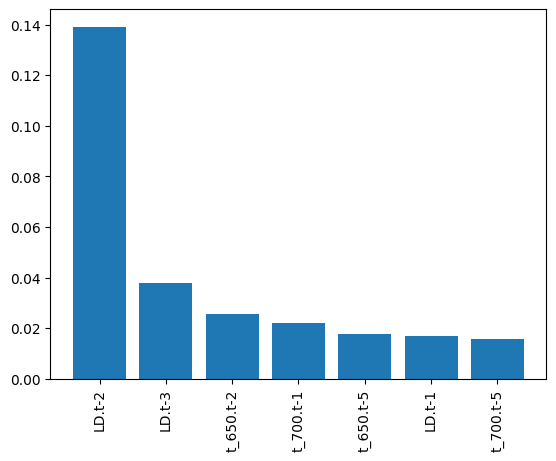

In [ ]:
import matplotlib.pyplot as plt

plt.bar(categorical_hail_no_sampling_important_features_names, categorical_hail_no_sampling_important_features_values)
plt.xticks(rotation='vertical')  # This line sets the x-axis labels to be vertical
plt.show()

# Categorical Prediction Model (based on hail size) v2

- With sampling

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np

def train_and_predict_categorical_with_sampling(boosting_model, y_column, actual_name, pred_name, max_ratio):
    # Define the categorization function
    def categorize_hail_size(hail_size):
        if hail_size == 0:
            return 'no_hail'
        elif 0 < hail_size < 20:
            return 'non_severe_hail'
        elif 20 <= hail_size <= 50:
            return 'severe_hail'
        elif hail_size > 50:
            return 'seriously_severe_hail'

    # Apply categorization to training data
    y_train_filled = y_train[y_column].fillna(0)
    y_train_categorical = y_train_filled.apply(categorize_hail_size)

    # Combine X_train and y_train for resampling
    combined_train_data = pd.concat([X_train, y_train_categorical], axis=1)

    # Determine sampling sizes for each category
    category_counts = combined_train_data[y_train_categorical.name].value_counts()
    min_size = category_counts.min()
    max_size = min(min_size * max_ratio, category_counts.max())

    # Perform sampling to maintain the ratio
    sampled_data = []
    for category in category_counts.index:
        category_data = combined_train_data[combined_train_data[y_train_categorical.name] == category]
        sample_size = min(len(category_data), max_size)
        sampled_data.append(category_data.sample(n=sample_size, random_state=42))

    stratified_train_data = pd.concat(sampled_data).reset_index(drop=True)

    # Separate X_train and y_train after resampling
    X_train_stratified = stratified_train_data.drop(y_train_categorical.name, axis=1)
    y_train_stratified = stratified_train_data[y_train_categorical.name]

    # Encode categories to numerical values
    label_encoder = LabelEncoder()
    y_train_stratified_encoded = label_encoder.fit_transform(y_train_stratified)

    # Impute missing values in training data
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train_stratified)
    X_test_imputed = imputer.transform(X_test)

    # Fit the model
    boosting_model.fit(X_train_imputed, y_train_stratified_encoded)

    # Predict on test data
    y_pred = boosting_model.predict(X_test_imputed)

    # Encode test labels
    y_test_filled = y_test[y_column].fillna(0)
    y_test_categorical = y_test_filled.apply(categorize_hail_size)
    y_test_categorical_encoded = label_encoder.transform(y_test_categorical)

    # Evaluate the model
    f1_micro = f1_score(y_test_categorical_encoded, y_pred, average='micro')
    print(f"F1 Micro Score: {f1_micro:.2f}")

    # Predict on evaluation dataset
    X_to_predict_imputed = imputer.transform(X_eval)
    predictions = boosting_model.predict(X_to_predict_imputed)
    df_pred[pred_name] = label_encoder.inverse_transform(predictions)

    # Apply the same categorization to the hail size data in the evaluation dataset and add to df_pred
    df_eval_filled = df_eval[y_column].fillna(0)
    df_eval_categorical = df_eval_filled.apply(categorize_hail_size)
    df_pred[actual_name] = df_eval_categorical

In [ ]:
# Training the model for categorical classification
categorical_hail_with_sampling_boosting_model = xgb.XGBClassifier(
    objective='multi:softprob',   # Multi-class classification
    n_estimators=50,              # Number of boosting rounds
    learning_rate=0.1,            # Learning rate
    max_depth=4,                  # Maximum depth of each tree
    random_state=42,
    num_class=4                   # Number of classes
)

In [ ]:
train_and_predict_categorical_with_sampling(
    boosting_model=categorical_hail_with_sampling_boosting_model,
    y_column='hail_size',
    actual_name='hail_size_with_sampling_categorical',
    pred_name='pred_hail_size_with_sampling_categorical',
    max_ratio=2
)

F1 Micro Score: 0.70


In [ ]:
categorical_hail_with_sampling_important_features = find_important_features(
    boosting_model=categorical_hail_with_sampling_boosting_model,
    limit=0.01
)

In [ ]:
categorical_hail_with_sampling_important_features

[[1253, 'LD.t-3', 0.031593989580869675],
 [1252, 'LD.t-4', 0.027025118470191956],
 [1041, 't_700.t+2', 0.016533153131604195],
 [46, 't_750.t-6', 0.01610935479402542],
 [1251, 'LD.t-5', 0.014933981001377106],
 [498, 'cape_depth_90.t-3', 0.014019681140780449]]

In [ ]:
categorical_hail_with_sampling_important_features_names = [feature[1] for feature in categorical_hail_with_sampling_important_features]
categorical_hail_with_sampling_important_features_values = [feature[2] for feature in categorical_hail_with_sampling_important_features]

In [ ]:
categorical_hail_with_sampling_important_features_names

['LD.t-3', 'LD.t-4', 't_700.t+2', 't_750.t-6', 'LD.t-5', 'cape_depth_90.t-3']

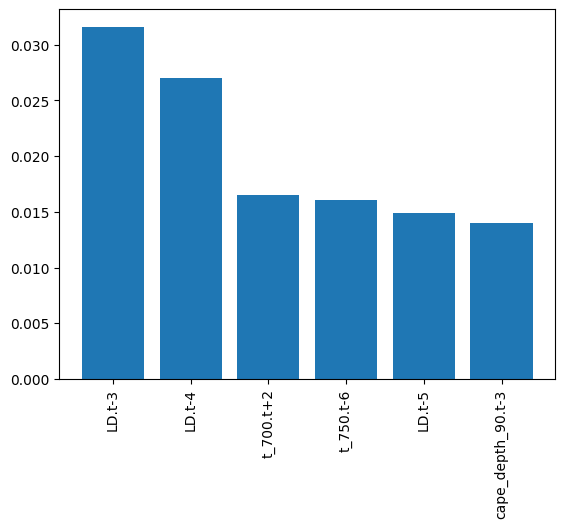

In [ ]:
import matplotlib.pyplot as plt

plt.bar(categorical_hail_with_sampling_important_features_names, categorical_hail_with_sampling_important_features_values)
plt.xticks(rotation='vertical')  # This line sets the x-axis labels to be vertical
plt.show()

# Results for `pred_hail_size_categorical`

In [ ]:
import numpy as np

def cat_contingency_table(y_true, y_pred, category):
    H = np.sum((y_true == category) & (y_pred == category))  # Hits
    M = np.sum((y_true == category) & (y_pred != category))  # Misses
    F = np.sum((y_true != category) & (y_pred == category))  # False alarms
    C = np.sum((y_true != category) & (y_pred != category))  # Correct negatives
    return H, M, F, C

def cat_POD(H, M, F, C):
    return H / (H + M) if H + M > 0 else 0

def cat_POFD(H, M, F, C):
    return F / (F + C) if F + C > 0 else 0

def cat_compute_scores(y_true, y_pred, category):
    H, M, F, C = cat_contingency_table(y_true, y_pred, category)
    pod = cat_POD(H, M, F, C)
    pofd = cat_POFD(H, M, F, C)
    pss = pod - pofd
    print(f"""
Category: {category}
H | F   {H:4} | {F:4}
----- = -------------
M | C   {M:4} | {C:4}

POD   = {pod:0.3}
POFD  = {pofd:0.3}
PSS   = {pss:0.3}
           """)
    return H, M, F, C, pss, pod, pofd

In [ ]:
# Apply cat_compute_scores for all four categories
categories = ['no_hail', 'non_severe_hail', 'severe_hail', 'seriously_severe_hail']
y_true = df_pred['hail_size_no_sampling_categorical']
y_pred = df_pred['pred_hail_size_no_sampling_categorical']

print('===== No Sampling =====')
for category in categories:
    cat_compute_scores(y_true, y_pred, category)

===== No Sampling =====

Category: no_hail
H | F    201 |    9
----- = -------------
M | C      4 |  724

POD   = 0.98
POFD  = 0.0123
PSS   = 0.968
           

Category: non_severe_hail
H | F    125 |   26
----- = -------------
M | C    258 |  529

POD   = 0.326
POFD  = 0.0468
PSS   = 0.28
           

Category: severe_hail
H | F    288 |  289
----- = -------------
M | C     26 |  335

POD   = 0.917
POFD  = 0.463
PSS   = 0.454
           

Category: seriously_severe_hail
H | F      0 |    0
----- = -------------
M | C     36 |  902

POD   = 0.0
POFD  = 0.0
PSS   = 0.0
           


In [ ]:
# Apply cat_compute_scores for all four categories
categories = ['no_hail', 'non_severe_hail', 'severe_hail', 'seriously_severe_hail']
y_true = df_pred['hail_size_with_sampling_categorical']
y_pred = df_pred['pred_hail_size_with_sampling_categorical']

print('===== With Sampling =====')
for category in categories:
    cat_compute_scores(y_true, y_pred, category)

===== With Sampling =====

Category: no_hail
H | F    195 |   23
----- = -------------
M | C     10 |  710

POD   = 0.951
POFD  = 0.0314
PSS   = 0.92
           

Category: non_severe_hail
H | F    156 |   74
----- = -------------
M | C    227 |  481

POD   = 0.407
POFD  = 0.133
PSS   = 0.274
           

Category: severe_hail
H | F    196 |  213
----- = -------------
M | C    118 |  411

POD   = 0.624
POFD  = 0.341
PSS   = 0.283
           

Category: seriously_severe_hail
H | F      9 |   72
----- = -------------
M | C     27 |  830

POD   = 0.25
POFD  = 0.0798
PSS   = 0.17
           


In [ ]:
# Combined contingency table for all categories
def combined_contingency_table(y_true, y_pred, categories):
    # Initialize counters
    H, M, F, C = 0, 0, 0, 0

    # Iterate through each category and update the counts
    for category in categories:
        H += np.sum((y_true == category) & (y_pred == category))  # Hits
        M += np.sum((y_true == category) & (y_pred != category))  # Misses
        F += np.sum((y_true != category) & (y_pred == category))  # False alarms
        C += np.sum((y_true != category) & (y_pred != category))  # Correct negatives

    return H, M, F, C

# Combined POD and POFD functions
def combined_POD(H, M, F, C):
    return H / (H + M) if H + M > 0 else 0

def combined_POFD(H, M, F, C):
    return F / (F + C) if F + C > 0 else 0

# Function to compute combined scores across all categories
def compute_combined_scores(y_true, y_pred, categories):
    H, M, F, C = combined_contingency_table(y_true, y_pred, categories)
    pod = combined_POD(H, M, F, C)
    pofd = combined_POFD(H, M, F, C)
    pss = pod - pofd
    print(f"""
Combined Scores for All Categories:
H | F   {H:4} | {F:4}
----- = -------------
M | C   {M:4} | {C:4}

POD   = {pod:0.3}
POFD  = {pofd:0.3}
PSS   = {pss:0.3}
           """)
    return H, M, F, C, pss, pod, pofd

In [ ]:
# Apply compute_combined_scores for all categories
categories = ['no_hail', 'non_severe_hail', 'severe_hail', 'seriously_severe_hail']
y_true = df_pred['hail_size_no_sampling_categorical']
y_pred = df_pred['pred_hail_size_no_sampling_categorical']

_ = compute_combined_scores(y_true, y_pred, categories)


Combined Scores for All Categories:
H | F    614 |  324
----- = -------------
M | C    324 | 2490

POD   = 0.655
POFD  = 0.115
PSS   = 0.539
           


In [ ]:
# Apply compute_combined_scores for all categories
categories = ['no_hail', 'non_severe_hail', 'severe_hail', 'seriously_severe_hail']
y_true = df_pred['hail_size_with_sampling_categorical']
y_pred = df_pred['pred_hail_size_with_sampling_categorical']

_ = compute_combined_scores(y_true, y_pred, categories)


Combined Scores for All Categories:
H | F    556 |  382
----- = -------------
M | C    382 | 2432

POD   = 0.593
POFD  = 0.136
PSS   = 0.457
           
